# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 14, 31, 42, 461862)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
from dataclasses import dataclass

@dataclass
class Place:
    url: str
    country: str
    city: str
    street: str
    csv: str = None
    lat: str = None   # optional
    lon: str = None   # optional

project = hopsworks.login()
fs = project.get_feature_store() 
secrets = hopsworks.get_secrets_api()
today = datetime.date.today()

objs = []


for i in range(3):  # we have 3 locations 
    
    # This line will fail if you have not registered the AQICN_API_KEY as a secret in Hopsworks
    AQICN_API_KEY = secrets.get_secret("AQICN_API_KEY").value
    location_str = secrets.get_secret(f"SENSOR_LOCATION_JSON{i}").value
    
    
    location = json.loads(location_str)
    
    country=location['country']
    city=location['city']
    street=location['street']
    aqicn_url=location['aqicn_url']
    latitude=location['latitude']
    longitude=location['longitude']
    temp_obj = Place(
        url=aqicn_url,
        country=country,
        city=city,
        street=street,
        lat=latitude,
        lon=longitude)
    objs.append(temp_obj)



2025-11-18 14:31:42,487 INFO: Initializing external client
2025-11-18 14:31:42,487 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 14:31:43,875 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 14:31:45,473 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272012


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
models = {}
def safe_name(x):
    return (
        x.lower()
         .replace(" ", "_")
         .replace("å", "a")
         .replace("ä", "a")
         .replace("ö", "o")
    )



mr = project.get_model_registry()
for idx, obj in enumerate(objs):
    retrieved_model = mr.get_model(
        name=f"air_quality_xgboost_model_{safe_name(obj.city)}",
        version=1,
    )

    fv = retrieved_model.get_feature_view()

    # Download the saved model artifacts to a local directory
    saved_model_dir = retrieved_model.download()

    # Loading the XGBoost regressor model and label encoder from the saved model directory
    # retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
    retrieved_xgboost_model = XGBRegressor()

    retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

    # Displaying the retrieved XGBoost regressor model
    models[obj.city] = retrieved_xgboost_model

print(models)

2025-11-18 14:31:54,978 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/585965 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/123945 elapsed<00:00 remaining<?

2025-11-18 14:32:06,726 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/599135 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/132079 elapsed<00:00 remaining<?

2025-11-18 14:32:15,829 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/402435 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/49250 elapsed<00:00 remaining<?

{'hedemora': XGBRegressor(base_score='2.2442732E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'i', 'i', 'i', 'i', 'i', 'i', 'i',
                            'i', 'i', 'i', 'i', 'i'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), 'w 675': XGBRegressor(base_score='7.78

In [6]:
print(models.keys())

dict_keys(['hedemora', 'w 675', 'W 911'])


## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
def add_month_feat(df):
    df = df.copy()

    # extract month number
    df["month"] = pd.to_datetime(df["date"]).dt.month

    # create OHE with all 12 possible months
    month_ohe = pd.get_dummies(df["month"], prefix="month")

    # ensure all 12 columns exist
    for m in range(1, 13):
        col = f"month_{m}"
        if col not in month_ohe.columns:
            month_ohe[col] = 0

    # order columns 1 → 12
    month_ohe = month_ohe[[f"month_{m}" for m in range(1, 13)]]

    return pd.concat([df, month_ohe], axis=1)

RUNNING hedemora NOW°!!!!!!!!!!!!!!!!!
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.52s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.66s) 
Index(['date', 'weather_temperature_2m_mean', 'weather_precipitation_sum',
       'weather_wind_speed_10m_max', 'weather_wind_direction_10m_dominant',
       'city', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'rolling1', 'rolling2', 'rolling3', 'predicted_pm25'],
      dtype='object')
2025-11-18 14:32:26,013 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272012/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 14:33:16,670 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 14:33:20,089 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 14:33:23,300 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 14:35:57,051 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 14:35:57,253 INFO: Waiting for log aggregation to finish.
2025-11-18 14:36:12,687 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.31s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.12s) 
            

Uploading Dataframe: 0.00% |          | Rows 0/0 | Elapsed Time: 00:00 | Remaining Time: ?


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272012/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 14:36:33,412 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 14:36:43,101 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 14:39:05,125 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 14:39:05,299 INFO: Waiting for log aggregation to finish.
2025-11-18 14:39:27,447 INFO: Execution finished successfully.


Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/docs/air-quality/assets/img/pm25_forecast_hedemora…

Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/docs/air-quality/assets/img/pm25_hindcast_1day_hed…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272012/settings/fb/path/Resources/airquality
RUNNING w 675 NOW°!!!!!!!!!!!!!!!!!
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.52s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 
Index(['date', 'weather_temperature_2m_mean', 'weather_precipitation_sum',
       'weather_wind_speed_10m_max', 'weather_wind_direction_10m_dominant',
       'city', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'rolling1', 'rolling2', 'rolling3', 'predicted_pm25'],
      dtype='object')


Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272012/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 14:40:15,552 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 14:40:18,765 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 14:42:07,880 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 14:42:08,037 INFO: Waiting for log aggregation to finish.
2025-11-18 14:42:33,541 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.33s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.07s) 
                          date   pm25
0    2021-09-20 00:00:00+00:00   9.72
4    2020-11-28 00:00:00+00:00   4.80
6    2023-09-0

Uploading Dataframe: 0.00% |          | Rows 0/0 | Elapsed Time: 00:00 | Remaining Time: ?


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272012/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 14:43:14,767 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 14:43:21,192 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 14:44:06,364 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-18 14:44:12,972 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 14:44:13,137 INFO: Waiting for log aggregation to finish.
2025-11-18 14:44:21,751 INFO: Execution finished successfully.


Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/docs/air-quality/assets/img/pm25_forecast_w 675.pn…

Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/docs/air-quality/assets/img/pm25_hindcast_1day_w 6…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272012/settings/fb/path/Resources/airquality
RUNNING W 911 NOW°!!!!!!!!!!!!!!!!!
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.43s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.50s) 
Index(['date', 'weather_temperature_2m_mean', 'weather_precipitation_sum',
       'weather_wind_speed_10m_max', 'weather_wind_direction_10m_dominant',
       'city', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'rolling1', 'rolling2', 'rolling3', 'predicted_pm25'],
      dtype='object')


Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272012/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 14:45:18,970 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 14:45:25,387 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 14:46:45,713 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 14:46:45,872 INFO: Waiting for log aggregation to finish.
2025-11-18 14:46:54,609 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.00s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.07s) 
                          date  pm25
14   2025-10-02 00:00:00+00:00  4.20
50   2025-10-25 00:00:00+00:00  3.60
55   2025-11-05 0

Uploading Dataframe: 0.00% |          | Rows 0/0 | Elapsed Time: 00:00 | Remaining Time: ?


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272012/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 14:47:16,206 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-18 14:47:19,475 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 14:47:22,694 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 14:48:07,713 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 14:48:07,873 INFO: Waiting for log aggregation to finish.
2025-11-18 14:48:16,525 INFO: Execution finished successfully.


Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/docs/air-quality/assets/img/pm25_forecast_W 911.pn…

Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/docs/air-quality/assets/img/pm25_hindcast_1day_W 9…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272012/settings/fb/path/Resources/airquality


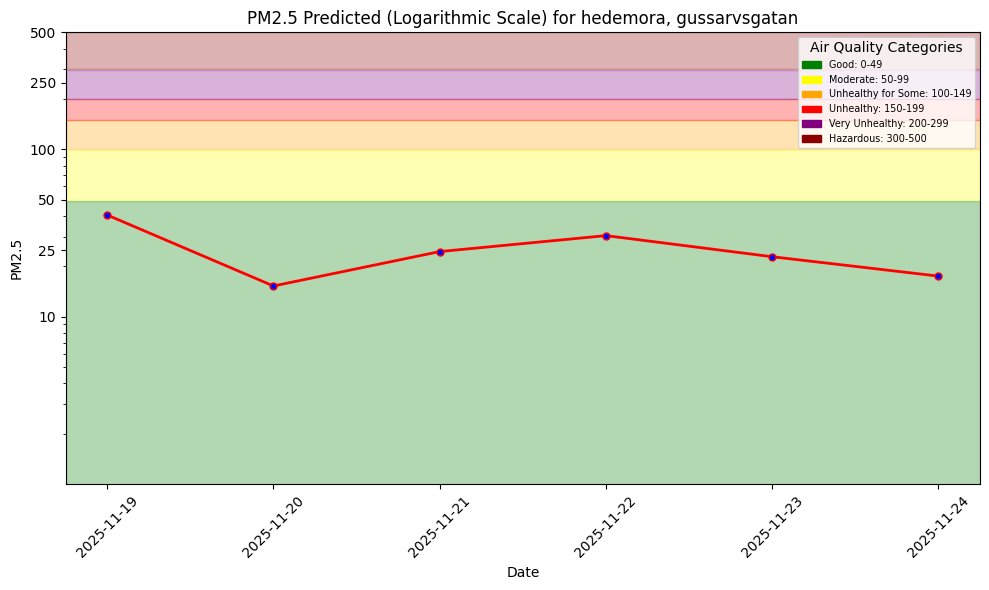

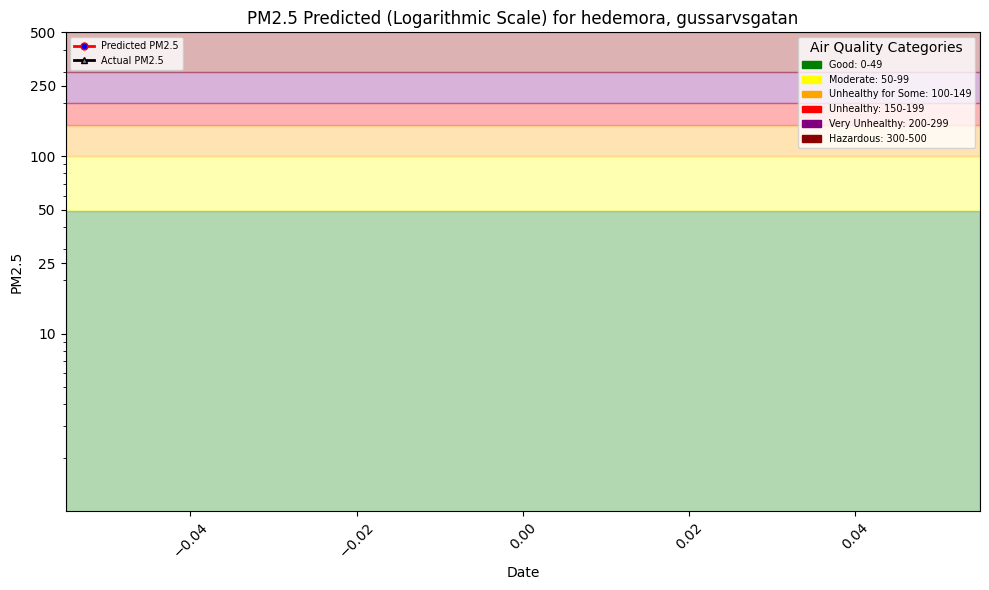

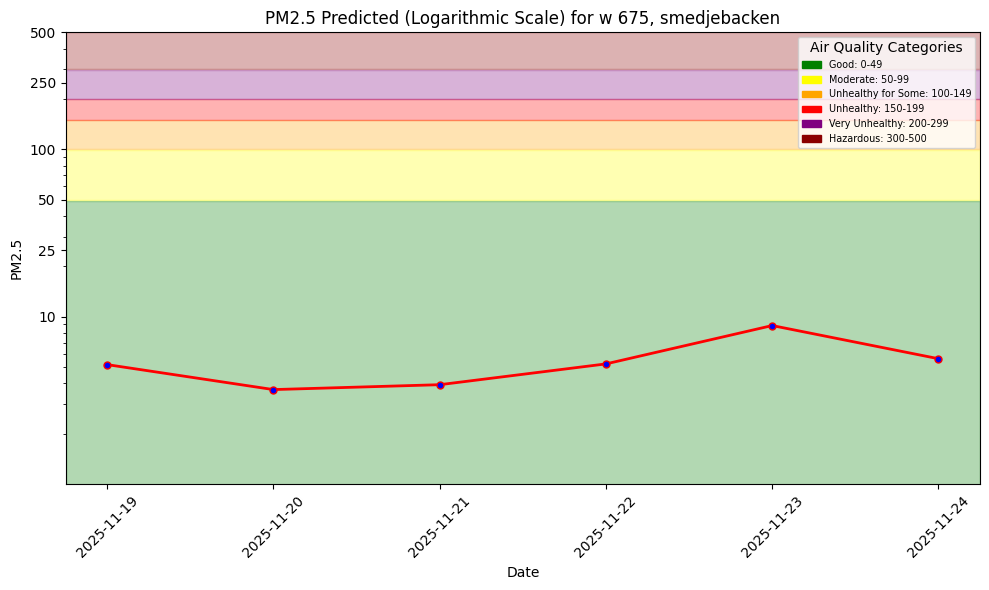

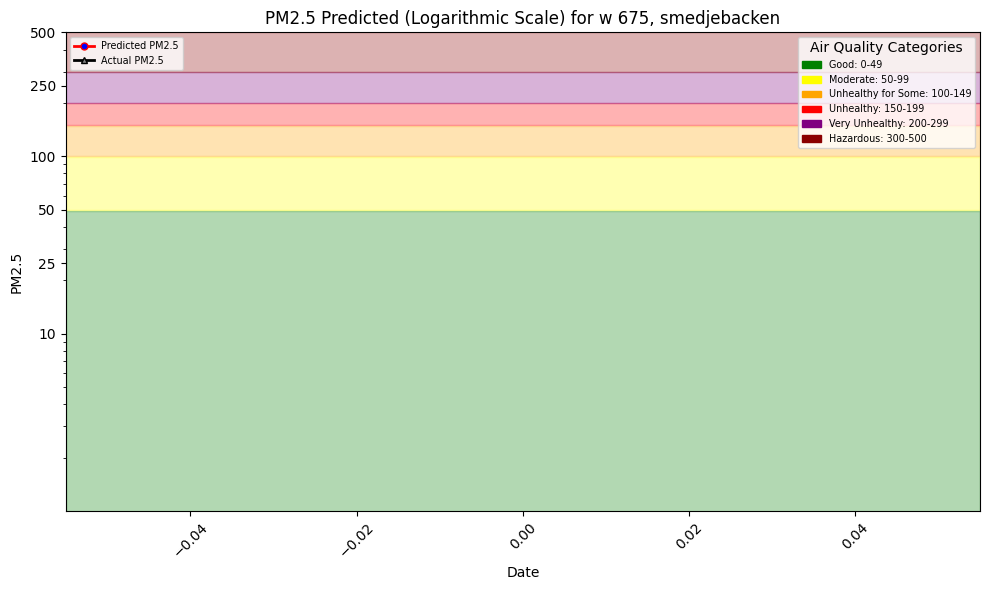

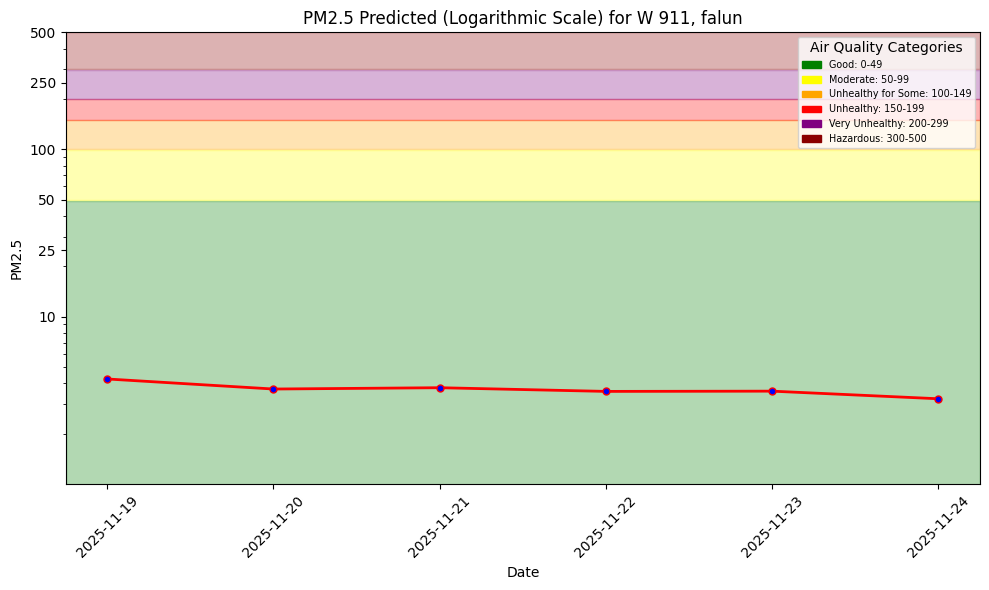

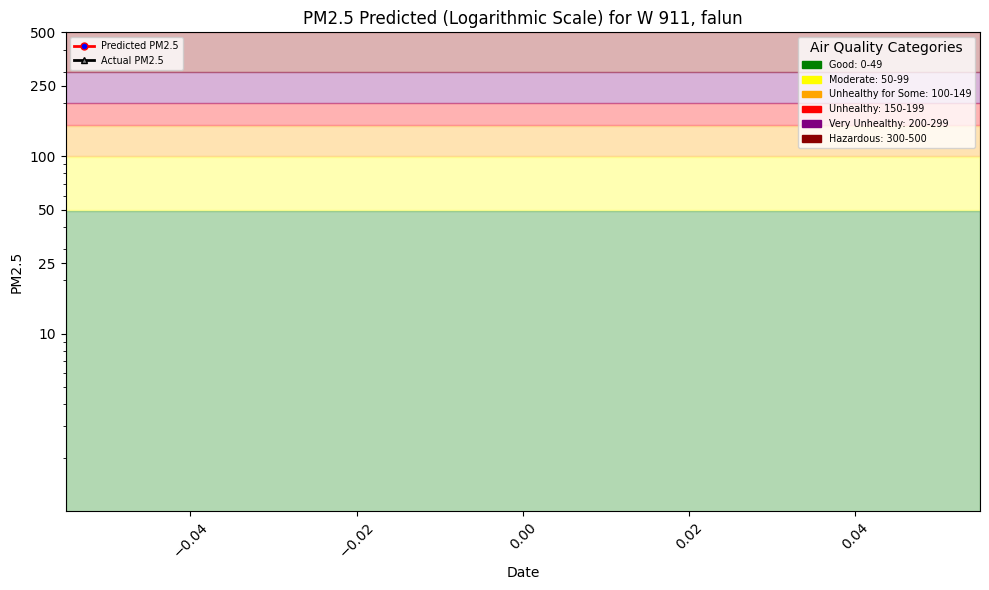

In [ ]:
import numpy as np

dfs = {}


weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)

# for later part
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)
dataset_api = project.get_dataset_api()


# loop 
for iiii, obj in enumerate(objs):
    print(f"RUNNING {obj.city} NOW°!!!!!!!!!!!!!!!!!")

    df_prev = (
        air_quality_fg
            .read()
    )
    df_prev = df_prev.loc[df_prev["city"] == obj.city]


    df_prev.sort_values('date', inplace=True)
    pm25_last3 = df_prev["pm25"].tail(3).to_list()

    pm25_3days_ago, pm25_2days_ago, pm25_1days_ago = pm25_last3

    batch_data = weather_fg.filter(weather_fg.date >= today).read()
    batch_data = batch_data.loc[batch_data["city"] == obj.city]

    batch_data = batch_data.rename(columns={
    "temperature_2m_mean": "weather_temperature_2m_mean",
    "precipitation_sum": "weather_precipitation_sum",
    "wind_speed_10m_max": "weather_wind_speed_10m_max",
    "wind_direction_10m_dominant": "weather_wind_direction_10m_dominant",
})

    batch_data = add_month_feat(batch_data)
    batch_data.drop(columns="month", inplace=True)

    # things we are missing: rolling
    batch_data.sort_values("date", inplace=True)
    batch_data[["rolling1", "rolling2", "rolling3", "predicted_pm25"]] = np.nan
    batch_data = batch_data.sort_values("date").reset_index(drop=True)

    model = models[obj.city]
    expected_cols = model.get_booster().feature_names


    print(batch_data.columns)
    for idx, row in batch_data.iterrows():

        batch_data.loc[idx, "rolling1"] = pm25_1days_ago
        batch_data.loc[idx, "rolling2"] = pm25_2days_ago
        batch_data.loc[idx, "rolling3"] = pm25_3days_ago

        batch_data =batch_data.astype({
        "rolling1": "float32",
        "rolling2": "float32",
        "rolling3": "float32"
        })
        
        # lets predict :)
        row = batch_data.loc[[idx], expected_cols]
        row = row.astype("float32")

        pred = model.predict(row)[0]

        batch_data.loc[idx, "predicted_pm25"] = pred

        pm25_3days_ago = pm25_2days_ago
        pm25_2days_ago = pm25_1days_ago
        pm25_1days_ago = pred

    batch_data =batch_data.astype({
        "predicted_pm25": "float32"
        })
    

    batch_data['street'] = obj.street
    batch_data['city'] = obj.city
    batch_data['country'] = obj.country
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
    batch_data = batch_data.sort_values(by=['date'])

#safe_name(obj.city)
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{safe_name(obj.city)}.png"
    plt = util.plot_air_quality_forecast(obj.city, obj.street, batch_data, pred_file_path)
    
    # next


    colinos = ['date', 'weather_temperature_2m_mean', 'weather_precipitation_sum',
        'weather_wind_speed_10m_max', 'weather_wind_direction_10m_dominant', 'city','predicted_pm25', 'street', 'country',
        'days_before_forecast_day']
    insetion = batch_data[colinos]

    monitor_fg.insert(insetion, wait=True)

    # We will create a hindcast chart for  only the forecasts made 1 day beforehand
    monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
    
    monitoring_df = monitoring_df.loc[monitoring_df["city"] == obj.city]

    air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
    air_quality_df = air_quality_fg.read()
    air_quality_df = air_quality_df.loc[air_quality_df["city"] == obj.city]



    outcome_df = air_quality_df[['date', 'pm25']]
    preds_df =  monitoring_df[['date', 'predicted_pm25']]
    
    print(outcome_df)
    print(preds_df)

    hindcast_df = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])


    # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
    if len(hindcast_df) == 0:
        hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
    
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{safe_name(obj.city)}.png"
    plt = util.plot_air_quality_forecast(obj.city, obj.street, hindcast_df, hindcast_file_path, hindcast=True)

    # last part 
    str_today = today.strftime("%Y-%m-%d")
    if dataset_api.exists("Resources/airquality") == False:
        dataset_api.mkdir("Resources/airquality")
    dataset_api.upload(pred_file_path, f"Resources/airquality/{obj.city}_{obj.street}_{str_today}", overwrite=True)
    dataset_api.upload(hindcast_file_path, f"Resources/airquality/{obj.city}_{obj.street}_{str_today}", overwrite=True)

    proj_url = project.get_url()
    print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")
    

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [9]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/docs/air-quality/assets/img/pm25_forecast_W 911.pn…

Uploading /Users/jarlstephansson/Desktop/ID2223/Lab1-ID2223/docs/air-quality/assets/img/pm25_hindcast_1day_W 9…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272012/settings/fb/path/Resources/airquality


---